In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Units
| Variable                                 	| Unit of Measurement 	|
|------------------------------------------	|----------------------	|
| $k$, permeability of the liver           	| $m^2$                	|
| $\mu_s$, viscosity of embolizing solution 	| $Pa \cdot s$         	|
| $\mu_o$, viscosity of blood               	| $Pa \cdot s$         	|
| distances                                	| $m$                  	|

| **Symbol**                  | **Description**                                | **Unit**           |
|-----------------------------|------------------------------------------------|--------------------|
| $ k $                     | Permeability of the liver                      | $ \mathrm{m}^2 $ |
| $ \mu_s $                 | Viscosity of embolizing solution               | $ \mathrm{Pa} \cdot \mathrm{s} $ |
| $ \mu_o $                 | Viscosity of blood                             | $ \mathrm{Pa} \cdot \mathrm{s} $ |
| $ \Omega $                | 3D Bulk Domain                                 | Dimensionless      |
| $ \Sigma $                | Cylindrical Vessel                             | Dimensionless      |
| $ \Gamma $                | Lateral Boundary of $ \Sigma $               | Dimensionless      |
| $ \Gamma_0, \Gamma_S $    | Top and Bottom Faces of $ \Sigma $           | Dimensionless      |
| $ \lambda(s) $            | $\mathcal{C}^2$-regular Curve (Centerline)    | $ \mathrm{m} $ (Parameter $ s $) |
| $ s $                     | Arc-length Parameter along $ \lambda $        | $ \mathrm{m} $   |
| $ \Lambda $               | Centerline of $ \Sigma $                      | Dimensionless      |
| $ \mathcal{D}(s) $        | Cross-section of $ \Sigma $                   | $ \mathrm{m}^2 $ |
| $ \partial \mathcal{D}(s) $| Boundary of Cross-section $ \mathcal{D}(s) $  | $ \mathrm{m} $   |
| $ u_{\oplus} $            | Fluid Potential in $ \Omega $ (Exterior)       | $ \mathrm{Pa} $  |
| $ u_{\ominus} $           | Fluid Potential in $ \Lambda $ (Interior)      | $ \mathrm{Pa} $  |
| $ \beta $                 | Coupling Coefficient                            | $ \frac{\mathrm{m}^3}{\mathrm{s} \cdot \mathrm{Pa}} $ |
| $ \kappa $                | Permeability Coefficient                        | $ \frac{\mathrm{m}^2}{\mathrm{s} \cdot \mathrm{Pa}} $ |
| $ g $                     | Source Term                                    | $ \frac{\mathrm{m}}{\mathrm{s}} $ |
| $ \alpha $                | Diffusion Coefficient                           | $ \frac{\mathrm{m}^2}{\mathrm{s} \cdot \mathrm{Pa}} $ |
| $ \Delta $                | Laplacian Operator                              | $ \frac{1}{\mathrm{m}^2} $ |
| $ \delta_{\Lambda} $      | Dirac Measure on $ \Lambda $                  | $ \frac{1}{\mathrm{m}^2} $ |
| $ f $                     | Forcing Term                                    | $ \frac{1}{\mathrm{s}} $ |
| $ \bar{u}_{\oplus} $      | Averaged Fluid Potential in $ \Omega $         | $ \mathrm{Pa} $  |
| $ \bar{u}_{\ominus} $     | Averaged Fluid Potential in $ \Lambda $        | $ \mathrm{Pa} $  |

In [2]:
# @title Install nonstandard libraries
%%capture
!pip install ipywidgets
!pip install vtk
!pip install meshio
!pip install pyvista

import os, re

def replace_in_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()

    # Replace 'ufl' with 'ufl_legacy'
    content = re.sub(r'\bufl\b', 'ufl_legacy', content)

    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(content)

def process_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                replace_in_file(file_path)

# dolfin
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"

# block
try:
    import block
except ImportError:
    !git clone "https://bitbucket.org/fenics-apps/cbc.block/src/master/"
    !pip install master/

# fenics_ii
try:
    import xii
except ImportError:
    !git clone "https://github.com/MiroK/fenics_ii"
    process_directory("fenics_ii/")
    !pip install fenics_ii/

# graphnics
try:
    import graphnics
except ImportError:
    !git clone "https://github.com/IngeborgGjerde/graphnics"
    !pip install graphnics/

In [3]:
WD_PATH = "/content/drive/MyDrive/Research/3D-1D"

import sys, os
sys.path.append(os.path.join(WD_PATH, 'modules'))
import visualizer
import coupler_sensitivity
import meshio
import scipy
import copy
import vtk
import json
import numpy as np
import matplotlib.pyplot as plt
import datetime
import networkx as nx
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import cKDTree
import importlib
from dolfin import *
from vtk.util.numpy_support import vtk_to_numpy
from xii import *
from graphnics import *

/usr/local/lib/python3.10/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [ ]:
# @title Define G = serena data graph
%%capture

G = FenicsGraph()
ind = 0
branch_points = {}

for n in range(29):
    file_path = os.path.join(WD_PATH, 'data', 'pv_json1', f'Centerline_{str(n)}.mrk.json')
    f = open(file_path)
    data = json.load(f)
    f.close()

    # get coords + radius at each point
    points = data['markups'][0]['controlPoints']
    radius = data['markups'][0]['measurements'][3]['controlPointValues']
    G.add_nodes_from(range(ind - n, ind + len(points) - n))

    # check if first coord is branch point from previous centerlines
    v1 = 0
    for key, val in branch_points.items():
        if points[0]['position'] == val:
            v1 = key
            break

    # add coords and radius to nodes fenics graph
    v2 = ind - n + 1
    pos_v1 = points[0]['position']
    pos_v2 = points[1]['position']
    G.nodes[v1]["pos"] = pos_v1
    G.nodes[v2]["pos"] = pos_v2
    G.nodes[v1]["radius"] = radius[0]
    G.nodes[v2]["radius"] = radius[1]
    # add edge to fenics graph
    G.add_edge(v1, v2)

    for i in range(len(points)-2):
        v1 = ind - n + 1 + i
        v2 = v1 + 1
        # convert coordinates from mm to meters (divide by 1000)
        pos_v1 = [coord / 1000 for coord in points[0]['position']]
        pos_v2 = [coord / 1000 for coord in points[1]['position']]
        pos_v1 = points[i + 1]['position']
        pos_v2 = points[i + 2]['position']
        G.nodes[v1]["pos"] = pos_v1
        G.nodes[v2]["pos"] = pos_v2
        G.nodes[v1]["radius"] = radius[i + 1]
        G.nodes[v2]["radius"] = radius[i + 2]
        G.add_edge(v1, v2, radius=radius[i+1])

    # store last point as a branch point
    ind += len(points)
    branch_points.update({ind-n-1: pos_v2})

In [12]:
# @title Define G = .vtk domain read
%%capture

# function to read .vtk file and extract information
def read_vtk(file_path):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    output = reader.GetOutput()
    G = FenicsGraph()

    for i in range(output.GetNumberOfPoints()):
        point = output.GetPoint(i)
        damage_value = output.GetPointData().GetArray("Damage").GetValue(i)
        radius_value = output.GetPointData().GetArray("Radius").GetValue(i)
        G.add_node(i, pos=tuple(point), radius=radius_value, damage=damage_value)

    for i in range(output.GetNumberOfCells()):
        cell = output.GetCell(i)
        for j in range(cell.GetNumberOfPoints() - 1):
            G.add_edge(cell.GetPointId(j), cell.GetPointId(j + 1))

    return G

# file_path = WD_PATH + '/data/vtk/sortedDomain.vtk'
file_path = WD_PATH + '/oncopigReferenceData/ZPAF23S018/20230531/vesselNetwork_upDated.vtk'
G = read_vtk(file_path)

In [13]:
def filter_small_components(G, threshold=20):
  """
  Removes connected components from the graph G that have a total length
  (sum of edge lengths) less than the specified threshold.

  Args:
    G: The networkx graph to process.
    threshold: The minimum total length for a component to be kept.
  """

  # Convert to undirected graph
  G_undirected = G.to_undirected()

  # Find connected components
  components = list(nx.connected_components(G_undirected))

  # Calculate total length for each component
  for component in components:
    total_length = 0
    for u, v in G_undirected.subgraph(component).edges():
      pos_u = G_undirected.nodes[u]['pos']
      pos_v = G_undirected.nodes[v]['pos']
      length = ((pos_u[0] - pos_v[0])**2 +
                (pos_u[1] - pos_v[1])**2 +
                (pos_u[2] - pos_v[2])**2) ** 0.5
      total_length += length

    # Remove component if total length is below threshold
    if total_length < threshold:
      G.remove_nodes_from(component)  # Remove from the original directed graph

# Apply the filtering
filter_small_components(G)

# @title Clean graph (only for raw .vtk domain reads)
def cleanup_graph(G):
    G.remove_nodes_from(list(nx.isolates(G)))
    G = nx.convert_node_labels_to_integers(G)

    # Merge close nodes
    positions = nx.get_node_attributes(G, 'pos')
    positions_array = np.array(list(positions.values()))
    tree = cKDTree(positions_array)
    merged_nodes = set()

    for node, pos in positions.items():
        # Find nearby nodes within the threshold distance
        nearby_nodes = tree.query_ball_point(pos, 1.0e-4)

        # Merge with the first nearby node (if any) that hasn't been merged yet
        for other_node in nearby_nodes:
            if other_node != node and other_node not in merged_nodes:
                G = nx.contracted_nodes(G, node, other_node)
                merged_nodes.add(other_node)
                break  # Stop after merging with one node

    # Set zero radii to 0.1
    for node in G.nodes():
        if G.nodes[node]['radius'] == 0:
            G.nodes[node]['radius'] = 0.1

    return G

G = cleanup_graph(G)

In [14]:
import FEMSensitivity
# k = 5.0e-12
# mu_o = 8.9e-4
k = 9.44e-3
mu_o = 4.5e-3
P_cvp = 5 #mmHg
P_in = 100 #mmHg

test = FEMSensitivity.FEMSensitivity(
  G,
  kappa = 1.0,
  alpha = k / mu_o,
  beta = 6.0e+4 * (k / mu_o),
  gamma = 0.2,
  del_Omega = P_cvp * 133.322, # Pa
  P_infty = P_in * 133.322 # Pa
)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_86765630720c088a2ad90ee684d3948b5df76d5b

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0106342 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_22bb736b850c370ac1741e1a80b6653eae2ad213

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00324178 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0224378 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_cdd21d347a8b939a40c5cd04a75bdb0e0e4b85cb

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00475621 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.200355 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_7a13db3e62df35cb076482f827a4c3a63ea1ca80

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00651622 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0602469 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_99e64e64a0b0bf7efa2745c3166b98a12c5ca04c

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00746274 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0407283 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_126d10369d899c6e8fe3cfd6abc2ba3582fddee0

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_43, f_88]'
  Unique elements:           'DG1(?,?), R0(?,?), CG2(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'DG1(?,?), R0(?,?), CG2(?,?), Vector<3 x CG1(?,?)>, CG1
                             (?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3294d58f0f50f8f3d952fd6e78eacbf5aeca5372

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0044055 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0216055 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_0df2929cb9b35191428c0030a1cad001c7380659

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00755906 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing r

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_423b18801bf7183da298802b56dd74beaef171df

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00551629 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0151522 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_a7bbc4e00090ff697d3dff5f421e847547646588

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0070734 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.019732 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_1e071d81b6a37c614cb7eddc2fe7f657497fa6d7

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.005476 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0150259 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_b4796d66f628bfc00f7cec073791e9053ca9cb8b

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00627017 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0202937 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_de2da559a7b3c5fdbe0ac63bdfec541ebb02c328

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to tetrahedron.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_44]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0459278 seconds.

INFO:FFC:Compiler 

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_034616a025277419a92e7b98f5872000d114fcb8

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0031445 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0171399 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_e56f626fb8a3283a24be8e9c28b33f1893ee0e38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00458503 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0173426 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_cef14095b4e99ac2308e1bd0e841d6f68c778ac0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00912023 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0194652 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_b6c7c5ddd0807e95591ada59c5293d430d44e4dd

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00900865 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0149949 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_55b15ef23bee335cc11714f1fde71ea7298687a1

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_43, f_88]'
  Unique elements:           'DG1(?,?), CG1(?,?), R0(?,?), CG2(?,?), Vector<3 x CG1(
                             ?,?)>'
  Unique sub elements:       'DG1(?,?), CG1(?,?), R0(?,?), CG2(?,?), Vector<3 x CG1(
                             ?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> de

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_dcaf8e58ae8a3648880fa45ab62b22ce06fc7e2b

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_43, f_88]'
  Unique elements:           'CG1(?,?), DG1(?,?), R0(?,?), CG2(?,?), Vector<3 x CG1(
                             ?,?)>'
  Unique sub elements:       'CG1(?,?), DG1(?,?), R0(?,?), CG2(?,?), Vector<3 x CG1(
                             ?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> de

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0c9f7bcf2e7e16811bec36fb6fa61ea4fe39aaee

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 3
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                2
  Arguments:                           '(v_0, v_1)'
  Number of coefficients:              4
  Coefficients:                        '[f_43, f_45, f_46, f_88]'
  Unique elements:                     'CG1(?,?), R0(?,?), CG2(?,?), Vector<3 x CG1(
          

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f3c709e0cab95e93273d3939bb3fd223c4957d61

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_89]'
  Unique elements:           'DG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'DG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0332701 seconds.

INFO:FFC:Compi

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_43a9d834a85081e621ca7b83bd73fc33b578e135

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:                 3
  Number of cell subdomains:           0
  Number of exterior_facet subdomains: 0
  Rank:                                1
  Arguments:                           '(v_0)'
  Number of coefficients:              3
  Coefficients:                        '[f_46, f_48, f_90]'
  Unique elements:                     'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:                 'CG1(?,?), R0(?,?), Vector<3 x CG1(?,?)>'
  
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_db7c57c276aa873c2e76b04d9df9a0b950329818

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    3
  Coefficients:              '[f_43, f_45, f_88]'
  Unique elements:           'CG1(?,?), R0(?,?), CG2(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), CG2(?,?), Vector<3 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:F

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1fea62d42fa244a02a16d06692811e415c18dfcf

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_88, 1D Pressure, f_174]'
  Unique elements:           'DG1(?,?), CG2(?,?), CG1(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'DG1(?,?), CG2(?,?), CG1(?,?), Vector<3 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5bb646a402f1d4362b740976238e67eb41e26b75

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to interval3D.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       3
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_88, 1D Pressure, f_174]'
  Unique elements:           'CG1(?,?), CG2(?,?), Vector<3 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), CG2(?,?), Vector<3 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 4
INFO:FFC:  quadrature_degree: 4
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0355291 seconds.

IN

In [ ]:
importlib.reload(visualizer)

<module 'visualizer' from '/content/drive/MyDrive/Research/3D-1D/modules/visualizer.py'>

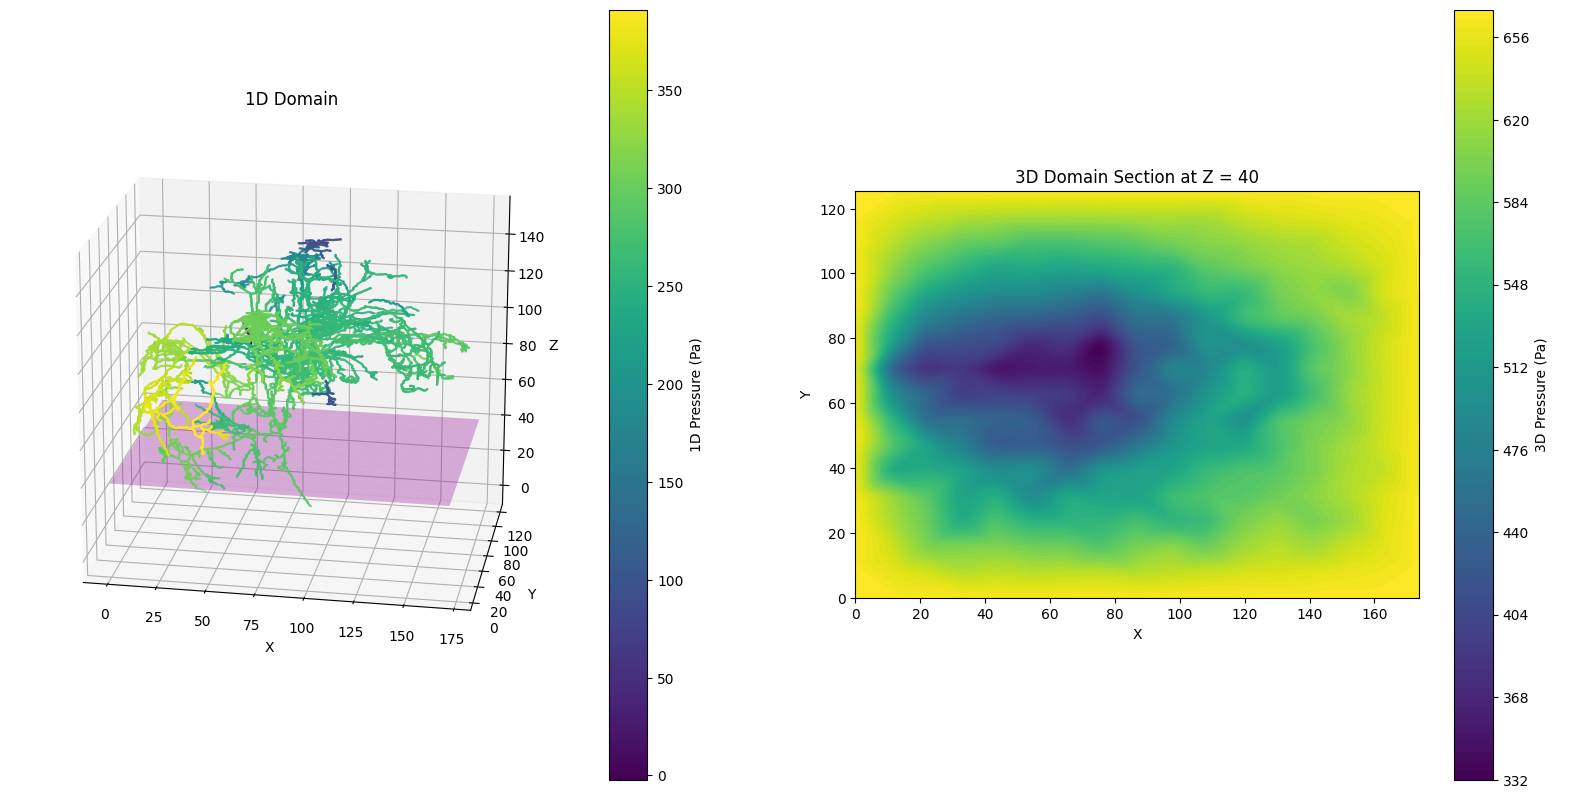

In [16]:
visualizer.visualize(test.Lambda, test.uh1d, mesh3d=test.Omega, sol3d=test.uh3d, elev=20, azim=-80, z_level=40)

In [17]:
test.save_vtk(os.path.join(WD_PATH, 'perfusion_results', 'test2'))